## Transfer learning and fine tuning with EfficinetnetB0

# Data preprocessing

In [1]:
  from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/prova_NN

Mounted at /gdrive
/gdrive/MyDrive/prova_NN


In [2]:
import os
import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tqdm.notebook import tqdm
import cv2

print(tf.__version__)

# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

2.7.0


In [3]:
dataset_dir = 'balanced'

In [ ]:
input_shape = (224, 224, 3)
epochs = 10
img_height = 224
img_width = 224
batch_size = 16
validation_split = 0.15

In [4]:
def custom_preprocess(image, probs = [0.4, 0.2, 0.2, 0.3]):
    """ probs are a list of length 3
      prob[0] constrols the noise added to the black background
      prob[1] constrols swapping of color channels
      prob[2] constrols HSV hue of the image
      prob[3] constrols blurring of image
      """
      # see https://stackoverflow.com/questions/57265893/change-colors-with-imagedatagenerator
    # Generate random values
    A,B,C,D = np.random.rand(4)
    
    # Define propabilites for each of the three augmentations
    if len(probs) != 4:
        raise ValueError("Lenght of threshold should be 3")
    else:
        thresholds = probs
        
    
    # Adds noise in the black background
    if A <= thresholds[0]:
        BACKGROUND_VALUE = 0 # Here I assume that 0 is the background colour
        size = image[image==BACKGROUND_VALUE].shape[0] 
        values = np.random.uniform(low=image.min(), high=image.max(), size=(size,))
        image[image==0] = values
    
    # Swap color channels
    if B <= thresholds[1]:
        dims = np.arange(3)
        np.random.shuffle(dims)
        image = image[...,[dims[0],dims[1],dims[2]]]
    
    # Change the hue of the image
    if C <= thresholds[2]:
        image = np.uint8(np.array(image))
        image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
        image = image.astype(np.float32)
        
    # Blurs the image slightly
    if D <= thresholds[3]:
        image = cv2.blur(image,(5,5))
    return image

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Efficientnet does not want rescaling, it is already built in
aug_train_data_gen = ImageDataGenerator(validation_split=validation_split,
    rotation_range = 45,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    brightness_range = [0.3,1.3],
    shear_range = 10,
    zoom_range = [0.3,1.2],
    channel_shift_range = 40,
    horizontal_flip  = True,
    vertical_flip = True,
    preprocessing_function = custom_preprocess,
)

aug_val_data_gen = ImageDataGenerator(
    validation_split = validation_split,
)

aug_train_gen =  aug_train_data_gen.flow_from_directory(
    directory = dataset_dir,
    target_size = (img_height,img_width),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle = True,
    seed = seed,
    subset = 'training'
)

val_train_gen = aug_val_data_gen.flow_from_directory(
    directory = dataset_dir,
    target_size = (img_height,img_width),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle = True,
    seed = seed,
    subset = 'validation'
)

Found 15076 images belonging to 14 classes.
Found 2652 images belonging to 14 classes.


# Transfer learning

used efficientnetB0, we load the imagenet weights and freeze them to train the classifier on top

In [5]:
from tensorflow.keras.applications import EfficientNetB0

In [9]:
def build_model():
    inputs = tfkl.Input(shape=input_shape)
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freezing the pretrained weights
    model.trainable = False

    # adding gap on top
    x = tfkl.GlobalAveragePooling2D(name="gap")(model.output)
    x = tfkl.BatchNormalization()(x)

    x = tfkl.Dropout(0.2, name="dropout")(x)
    outputs =tfkl.Dense(14, activation="softmax", name="output")(x)

    model = tfk.Model(inputs, outputs, name="EfficientNet")
    
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-2), loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
model = build_model()
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 224, 224, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                       

In [ ]:
history = model.fit(
    x = aug_train_gen,
    epochs = 10,
    validation_data = val_train_gen
).history

Epoch 1/10
898/898 [==============================] - 2780s 3s/step - loss: 2.0802 - accuracy: 0.5955 - val_loss: 0.4775 - val_accuracy: 0.8433
Epoch 2/10
898/898 [==============================] - 1060s 1s/step - loss: 1.2843 - accuracy: 0.6518 - val_loss: 0.3391 - val_accuracy: 0.9020
Epoch 3/10
898/898 [==============================] - 1113s 1s/step - loss: 1.1351 - accuracy: 0.6580 - val_loss: 0.5108 - val_accuracy: 0.8401
Epoch 4/10
898/898 [==============================] - 1121s 1s/step - loss: 1.1772 - accuracy: 0.6491 - val_loss: 0.3971 - val_accuracy: 0.8766
Epoch 5/10
898/898 [==============================] - 1145s 1s/step - loss: 1.2177 - accuracy: 0.6469 - val_loss: 0.4370 - val_accuracy: 0.8464
Epoch 6/10
898/898 [==============================] - 1108s 1s/step - loss: 1.2359 - accuracy: 0.6414 - val_loss: 0.3061 - val_accuracy: 0.9099
Epoch 7/10
898/898 [==============================] - 1085s 1s/step - loss: 1.2464 - accuracy: 0.6461 - val_loss: 0.3605 - val_accuracy:

In [ ]:
model.save('Transfer_learning')

INFO:tensorflow:Assets written to: Transfer_learning/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


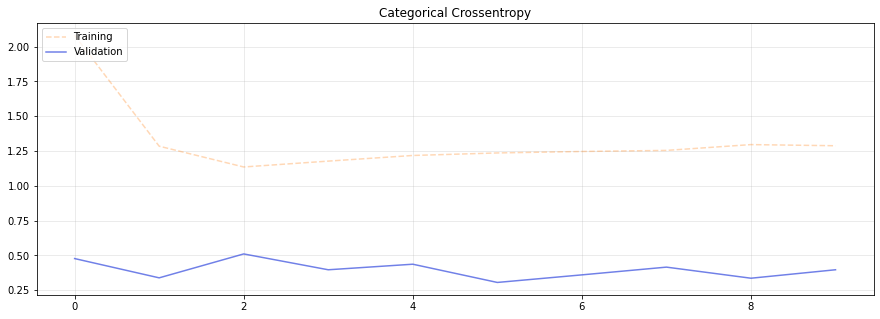

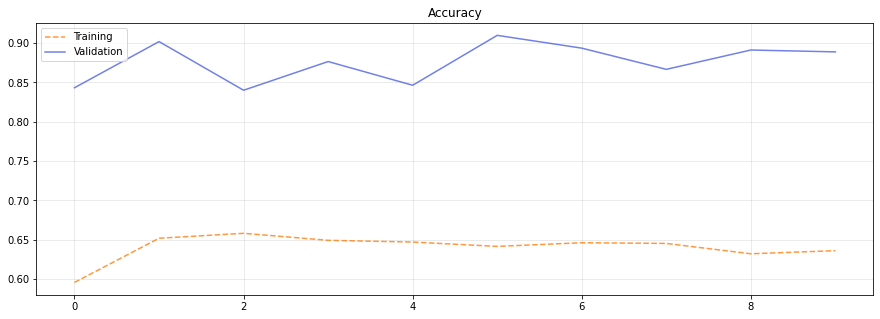

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
  model.compile(optimizer= tfk.optimizers.Adam(1e-3), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history = model.fit(
    x = aug_train_gen,
    epochs = 5,
    validation_data = val_train_gen
).history

Epoch 1/5
898/898 [==============================] - 1160s 1s/step - loss: 1.0006 - accuracy: 0.6987 - val_loss: 0.2349 - val_accuracy: 0.9405
Epoch 2/5
898/898 [==============================] - 1160s 1s/step - loss: 0.8806 - accuracy: 0.7228 - val_loss: 0.2402 - val_accuracy: 0.9381
Epoch 3/5
898/898 [==============================] - 1160s 1s/step - loss: 0.8302 - accuracy: 0.7322 - val_loss: 0.2342 - val_accuracy: 0.9444
Epoch 4/5
898/898 [==============================] - 1159s 1s/step - loss: 0.8438 - accuracy: 0.7301 - val_loss: 0.2264 - val_accuracy: 0.9444
Epoch 5/5
898/898 [==============================] - 1160s 1s/step - loss: 0.8286 - accuracy: 0.7319 - val_loss: 0.2114 - val_accuracy: 0.9544


In [ ]:
model.save('Transfer_learning')

INFO:tensorflow:Assets written to: Transfer_learning/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


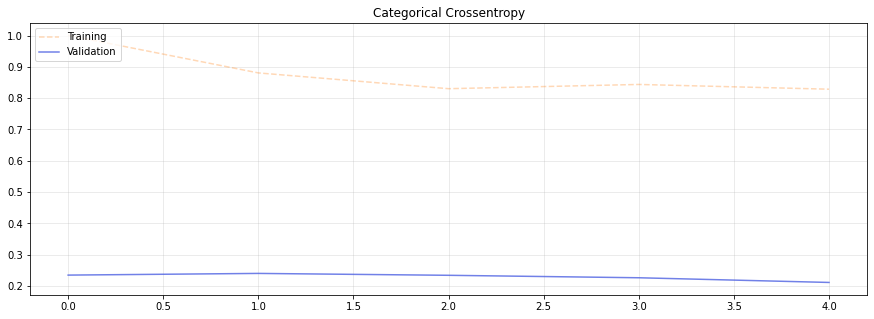

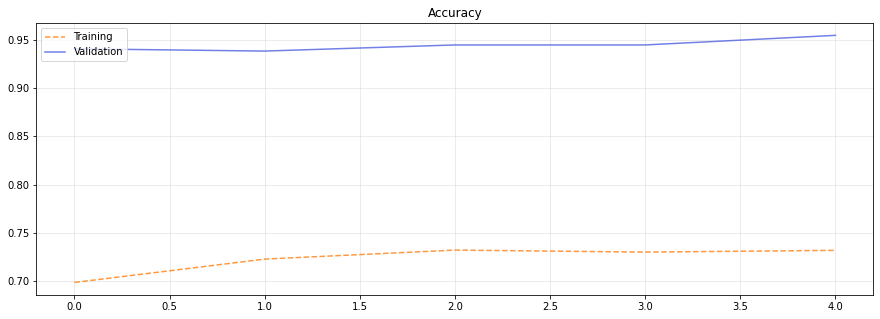

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

# Fine tuning

We unfreeze the top 15 layers while leaving BatchNorm layers frozen as it was shown to increase performance, we also decrease the learning rate to 1e-4

In [ ]:
modelft =  tfk.models.load_model('Transfer_learning')

In [ ]:
modelft.layers[-15:]

In [ ]:
for layer in modelft.layers[-15:]:
  if not isinstance(layer, tfkl.BatchNormalization):
    layer.trainable = True

In [ ]:
for layer in modelft.layers[:]:
  print(layer.trainable)

True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False

In [ ]:
modelft.compile(optimizer=tfk.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
modelft.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 224, 224, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                       

In [ ]:
historyft = modelft.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = val_train_gen
).history

Epoch 1/10
898/898 [==============================] - 1198s 1s/step - loss: 0.7426 - accuracy: 0.7604 - val_loss: 0.1392 - val_accuracy: 0.9548
Epoch 2/10
898/898 [==============================] - 1176s 1s/step - loss: 0.6561 - accuracy: 0.7880 - val_loss: 0.1262 - val_accuracy: 0.9663
Epoch 3/10
898/898 [==============================] - 1151s 1s/step - loss: 0.6167 - accuracy: 0.8030 - val_loss: 0.1053 - val_accuracy: 0.9730
Epoch 4/10
898/898 [==============================] - 1149s 1s/step - loss: 0.5691 - accuracy: 0.8129 - val_loss: 0.0932 - val_accuracy: 0.9726
Epoch 5/10
898/898 [==============================] - 1158s 1s/step - loss: 0.5608 - accuracy: 0.8176 - val_loss: 0.0847 - val_accuracy: 0.9758
Epoch 6/10
898/898 [==============================] - 1167s 1s/step - loss: 0.5387 - accuracy: 0.8253 - val_loss: 0.0767 - val_accuracy: 0.9813
Epoch 7/10
898/898 [==============================] - 1184s 1s/step - loss: 0.5004 - accuracy: 0.8390 - val_loss: 0.0579 - val_accuracy:

In [ ]:
modelft.save('Finetuned_model')

INFO:tensorflow:Assets written to: Finetuned_model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


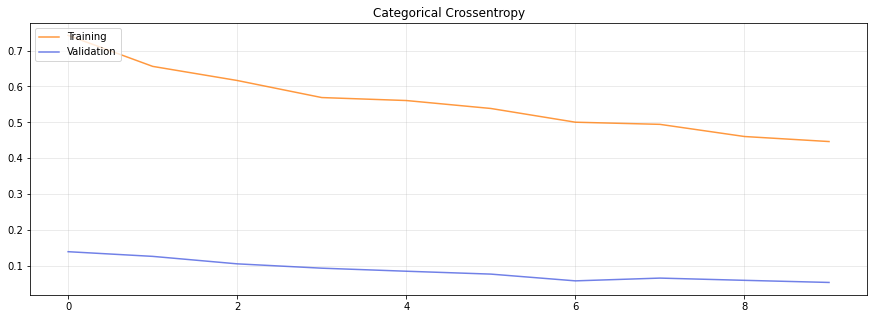

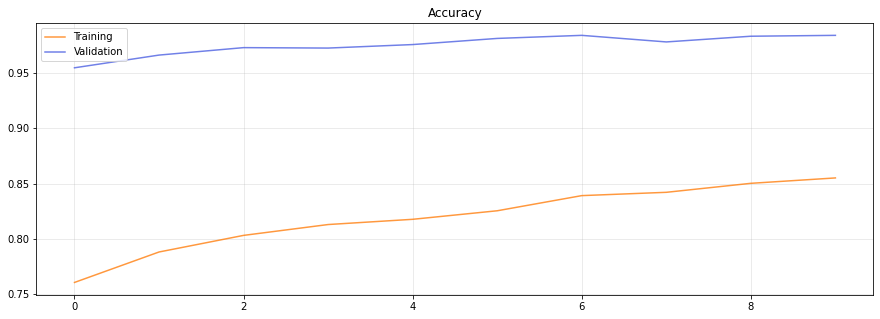

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(historyft['loss'], label='Training', alpha=.8, color='#ff7f0e',)
plt.plot(historyft['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(historyft['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(historyft['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
for layer in modelft.layers[-25:]:
  if not isinstance(layer, tfkl.BatchNormalization):
    layer.trainable = True

In [ ]:
modelft.compile(optimizer=tfk.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
historyft2 = modelft.fit(
    x = aug_train_gen,
    epochs = 5,
    validation_data = val_train_gen
).history

Epoch 1/5
898/898 [==============================] - 1219s 1s/step - loss: 0.4394 - accuracy: 0.8585 - val_loss: 0.0476 - val_accuracy: 0.9869
Epoch 2/5
898/898 [==============================] - 1208s 1s/step - loss: 0.4289 - accuracy: 0.8637 - val_loss: 0.0470 - val_accuracy: 0.9865
Epoch 3/5
898/898 [==============================] - 1205s 1s/step - loss: 0.4072 - accuracy: 0.8695 - val_loss: 0.0431 - val_accuracy: 0.9881
Epoch 4/5
898/898 [==============================] - 1196s 1s/step - loss: 0.3842 - accuracy: 0.8748 - val_loss: 0.0462 - val_accuracy: 0.9869
Epoch 5/5
898/898 [==============================] - 1187s 1s/step - loss: 0.3666 - accuracy: 0.8849 - val_loss: 0.0346 - val_accuracy: 0.9893


In [ ]:
modelft.save('Finetuned_model2')

INFO:tensorflow:Assets written to: Finetuned_model2/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
modelft = tfk.models.load_model('Finetuned_model2')

In [ ]:
modelft.compile(optimizer=tfk.optimizers.Adam(1e-5), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
historyft3 = modelft.fit(
    x = aug_train_gen,
    epochs = 3,
    validation_data = val_train_gen
).history

Epoch 1/3
898/898 [==============================] - 2846s 3s/step - loss: 0.3521 - accuracy: 0.8834 - val_loss: 0.0294 - val_accuracy: 0.9905
Epoch 2/3
898/898 [==============================] - 1034s 1s/step - loss: 0.3353 - accuracy: 0.8941 - val_loss: 0.0284 - val_accuracy: 0.9917
Epoch 3/3
898/898 [==============================] - 1035s 1s/step - loss: 0.3287 - accuracy: 0.8926 - val_loss: 0.0251 - val_accuracy: 0.9921


In [ ]:
modelft.save('Finetuned_model3')

INFO:tensorflow:Assets written to: Finetuned_model3/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


this model got 91,3% on the test set

# Weighted loss function and unbalanced dataset


i use the model trained on the balanced set as a starting point

In [ ]:
model2 = tfk.models.load_model('Finetuned_model2')

In [ ]:
dataset_dir = 'training'

In [ ]:
n_samples = 17728
n_classes = 14
n_per_class = [988, 467, 583, 1206, 1458, 1748, 977, 765, 716 , 264, 1616, 574, 673, 5693]
wheight = [0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in range(n_classes):
  wheight[i] = n_samples/(n_classes*n_per_class[i])


In [ ]:
wheight

[1.2816657027183342,
 2.711532578770266,
 2.1720166625827004,
 1.0499881544657663,
 0.8685087203605723,
 0.7244197450147107,
 1.296095920456207,
 1.6552754435107375,
 1.7685554668794892,
 4.796536796536796,
 0.7835926449787836,
 2.2060726729716276,
 1.8815538102313734,
 0.22242854633509823]

In [ ]:
class_wheight = {0: 1.2816657027183342,
                  1: 2.711532578770266,
                  2: 2.1720166625827004,
                  3: 1.0499881544657663,
                  4: 0.8685087203605723,
                  5: 0.7244197450147107,
                  6: 1.296095920456207,
                  7: 1.6552754435107375,
                  8: 1.7685554668794892,
                  9: 4.796536796536796,
                  10: 0.7835926449787836,
                  11: 2.2060726729716276,
                  12: 1.8815538102313734,
                  13: 0.22242854633509823}

In [ ]:
model2.compile(optimizer=tfk.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history2ft = model2.fit(
    x = aug_train_gen,
    epochs = 5,
    validation_data = val_train_gen,
    class_weight=class_wheight
).history

Epoch 1/5
943/943 [==============================] - 5676s 6s/step - loss: 0.3781 - accuracy: 0.8450 - val_loss: 0.0457 - val_accuracy: 0.9849
Epoch 2/5
943/943 [==============================] - 1145s 1s/step - loss: 0.3550 - accuracy: 0.8596 - val_loss: 0.0493 - val_accuracy: 0.9838
Epoch 3/5
943/943 [==============================] - 1200s 1s/step - loss: 0.3440 - accuracy: 0.8609 - val_loss: 0.0658 - val_accuracy: 0.9793
Epoch 4/5
943/943 [==============================] - 1212s 1s/step - loss: 0.3573 - accuracy: 0.8603 - val_loss: 0.0634 - val_accuracy: 0.9834
Epoch 5/5
943/943 [==============================] - 1255s 1s/step - loss: 0.3269 - accuracy: 0.8687 - val_loss: 0.0446 - val_accuracy: 0.9857


In [ ]:
model2.save('modelft_weighted')

INFO:tensorflow:Assets written to: modelft_weighted/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
model3 = tfk.models.load_model('modelft_weighted')

In [ ]:
model3.compile(optimizer=tfk.optimizers.Adam(1e-5), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history2ft3 = model3.fit(
    x = aug_train_gen,
    epochs = 5,
    validation_data = val_train_gen,
    class_weight=class_wheight
).history

Epoch 1/5
943/943 [==============================] - 2667s 3s/step - loss: 0.3434 - accuracy: 0.8644 - val_loss: 0.0381 - val_accuracy: 0.9883
Epoch 2/5
943/943 [==============================] - 1102s 1s/step - loss: 0.3003 - accuracy: 0.8774 - val_loss: 0.0376 - val_accuracy: 0.9887
Epoch 3/5
943/943 [==============================] - 1144s 1s/step - loss: 0.2966 - accuracy: 0.8809 - val_loss: 0.0424 - val_accuracy: 0.9887
Epoch 4/5
943/943 [==============================] - 1147s 1s/step - loss: 0.2970 - accuracy: 0.8796 - val_loss: 0.0410 - val_accuracy: 0.9887
Epoch 5/5
943/943 [==============================] - 1156s 1s/step - loss: 0.3028 - accuracy: 0.8780 - val_loss: 0.0420 - val_accuracy: 0.9883


In [ ]:
model3.save('modelft_weighted2')

INFO:tensorflow:Assets written to: modelft_weighted2/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


this model got 91.6% accuracy on the test set

i try now with small lr on the best model trained on the balanced set with no weights

In [ ]:
model4 = tfk.models.load_model('Finetuned_model3')

In [ ]:
model4.compile(optimizer=tfk.optimizers.Adam(1e-5), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history3ft3 = model4.fit(
    x = aug_train_gen,
    epochs = 3,
    validation_data = val_train_gen,
    class_weight=class_wheight
).history

Epoch 1/3
943/943 [==============================] - 1200s 1s/step - loss: 0.3579 - accuracy: 0.8303 - val_loss: 0.0576 - val_accuracy: 0.9834
Epoch 2/3
943/943 [==============================] - 1211s 1s/step - loss: 0.3375 - accuracy: 0.8497 - val_loss: 0.0595 - val_accuracy: 0.9830
Epoch 3/3
943/943 [==============================] - 1223s 1s/step - loss: 0.3435 - accuracy: 0.8545 - val_loss: 0.0503 - val_accuracy: 0.9849


In [ ]:
model3.save('modelft_weighted3')

INFO:tensorflow:Assets written to: modelft_weighted3/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


this model got slightly less accuracy than the previous model at 90.6%

I than tried to train the whole model using the original training set and the weighted loss function

In [ ]:
model = build_model()
model.summary()

In [ ]:
history = model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = val_train_gen,
    class_weight=class_wheight
).history

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
model.compile(optimizer= tfk.optimizers.Adam(1e-3), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history2 = model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = val_train_gen,
    class_weight=class_wheight
).history

In [ ]:
for layer in model.layers[-25:]:
  if not isinstance(layer, tfkl.BatchNormalization):
    layer.trainable = True

In [ ]:
model.compile(optimizer=tfk.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
historyft = model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = val_train_gen,
    class_weight=class_wheight
).history

In [ ]:
model.compile(optimizer=tfk.optimizers.Adam(1e-5), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
historyft2 = model.fit(
    x = aug_train_gen,
    epochs = 5,
    validation_data = val_train_gen,
    class_weight=class_wheight
).history

In [ ]:
model.save('Finetuned_model_w2')

this last model was submitted and scored 90% it seemed that the gain in accuracy in the underrapresented classes was smaller than the loss accuracy in the overrappresented ones.

# experiment with larger input size

Now trying to enlarge the input size, and transfer the weigts from the best model so far, then run a few epochs with low lr

In [6]:
input_shape = (300, 300, 3)
epochs = 10
img_height = 300
img_width = 300
batch_size = 16
validation_split = 0.15

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Efficientnet does not want rescaling, it is already built in
aug_train_data_gen = ImageDataGenerator(validation_split=validation_split,
    rotation_range = 45,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    brightness_range = [0.3,1.3],
    shear_range = 10,
    zoom_range = [0.3,1.2],
    channel_shift_range = 40,
    horizontal_flip  = True,
    vertical_flip = True,
    preprocessing_function = custom_preprocess,
)

aug_val_data_gen = ImageDataGenerator(
    validation_split = validation_split,
)

aug_train_gen =  aug_train_data_gen.flow_from_directory(
    directory = dataset_dir,
    target_size = (img_height,img_width),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle = True,
    seed = seed,
    subset = 'training'
)

val_train_gen = aug_val_data_gen.flow_from_directory(
    directory = dataset_dir,
    target_size = (img_height,img_width),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle = True,
    seed = seed,
    subset = 'validation'
)

Found 14364 images belonging to 14 classes.
Found 2520 images belonging to 14 classes.


In [10]:
model = build_model()
model.summary()

16719872/16705208 [==============================] - 0s 0us/step
Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 300, 300, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 300, 300, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPa

In [11]:
model.load_weights('modelft_weighted2')

In [13]:
model.compile(optimizer=tfk.optimizers.Adam(1e-5), loss="categorical_crossentropy", metrics=["accuracy"])

In [15]:
history = model.fit(
    x = aug_train_gen,
    epochs = 5,
    validation_data = val_train_gen
).history

Epoch 1/5
898/898 [==============================] - 3656s 4s/step - loss: 0.3275 - accuracy: 0.8952 - val_loss: 0.0287 - val_accuracy: 0.9929
Epoch 2/5
898/898 [==============================] - 1713s 2s/step - loss: 0.3249 - accuracy: 0.8945 - val_loss: 0.0271 - val_accuracy: 0.9929
Epoch 3/5
898/898 [==============================] - 1721s 2s/step - loss: 0.3257 - accuracy: 0.8957 - val_loss: 0.0272 - val_accuracy: 0.9933
Epoch 4/5
898/898 [==============================] - 1735s 2s/step - loss: 0.3159 - accuracy: 0.9000 - val_loss: 0.0255 - val_accuracy: 0.9925
Epoch 5/5
898/898 [==============================] - 1708s 2s/step - loss: 0.3123 - accuracy: 0.8974 - val_loss: 0.0267 - val_accuracy: 0.9929


In [16]:
model.save('efficientnet_large_input')

INFO:tensorflow:Assets written to: efficientnet_large_input/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


this improved the score to 92%